In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, unary_from_softmax

import os
import skimage.io as io
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from models import dice, mean_iou, preprocess_input
from utils import add_masks
import numpy as np
import json
from config import labels, hues, n_classes
from tensorflow.keras.utils import to_categorical

In [2]:
def plot_pair(images, titles):
  
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(16,8))
    i=0

    for y in range(2):
        axes[y].set_title(titles[i], size=24)
        axes[y].imshow(images[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i+=1

    plt.show()

In [3]:
def get_poly(annot_path):
    # reads in shape_dicts
    with open(annot_path) as handle:
        data = json.load(handle)

    shape_dicts = data['shapes']

    return shape_dicts

In [4]:
def draw_multi_masks(im, shape_dicts):
    
    blank = np.zeros(shape=im.shape, dtype=np.uint8)
    
    channels = []
    cls = [x['label'] for x in shape_dicts]
    poly = [np.array(x['points'], dtype=np.int32) for x in shape_dicts]
    label2poly = dict(zip(cls, poly))

    for i, label in enumerate(labels):
        
        if label in cls:
            cv2.fillPoly(blank, [label2poly[label]], (hues[label], 255, 255))
            
    return cv2.cvtColor(blank, cv2.COLOR_HSV2RGB)

In [5]:
def create_multi_masks(im, shape_dicts):
    
    channels = []
    cls = [x['label'] for x in shape_dicts]
    poly = [np.array(x['points'], dtype=np.int32) for x in shape_dicts]
    label2poly = dict(zip(cls, poly))
    background = np.zeros(shape=im.shape, dtype=np.float32)

    for i, label in enumerate(labels):
        
        blank = np.zeros(shape=im.shape, dtype=np.float32)
        
        if label in cls:
            cv2.fillPoly(blank, [label2poly[label]], 255)
            cv2.fillPoly(background, [label2poly[label]], 255)
            
        channels.append(blank)
    _, thresh = cv2.threshold(background, 127, 255, cv2.THRESH_BINARY_INV)
    channels.append(thresh)

    Y = np.stack(channels, axis=2)
    return Y

In [6]:
model = load_model(os.path.join('models', 'fcn_8.model'),
                   custom_objects={'dice': dice, 'mean_iou': mean_iou})

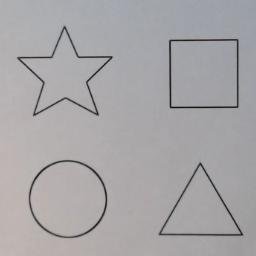

In [7]:
im_path = os.path.join('logs', '0.jpg')
im = cv2.imread(im_path, 1)
im_gray = cv2.imread(im_path, 0)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
display(Image.fromarray(im_rgb))

In [8]:
im = np.expand_dims(im_rgb, axis=0)
im_softmax = model.predict(im)
im_pred = np.squeeze(im_softmax) * 255.0
im_mask = add_masks(im_pred)

In [9]:
ann_path = os.path.join('annotated', '0.json')
shape_dicts = get_poly(ann_path)
im_true = draw_multi_masks(im_rgb, shape_dicts)
true_mask = create_multi_masks(im_gray, shape_dicts)

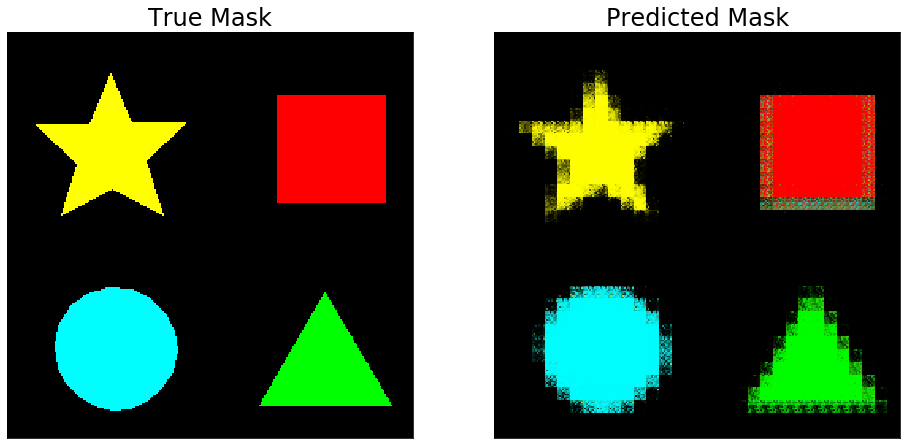

In [10]:
plot_pair([im_true, im_mask], ['True Mask', 'Predicted Mask'])

In [11]:
im_softmax = im_softmax.squeeze()
print(im_softmax.shape)

(256, 256, 5)


### CRF Mask

https://github.com/lucasb-eyer/pydensecrf/blob/master/examples/inference.py

In [12]:
feat_first = im_softmax.transpose((2, 0, 1)).reshape((n_classes,-1))
print(feat_first.shape)
unary = unary_from_softmax(feat_first)
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF2D(im_rgb.shape[1], im_rgb.shape[0], n_classes)

d.setUnaryEnergy(unary)
d.addPairwiseGaussian(sxy=(5, 5), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

# This adds the color-dependent term, i.e. features are (x,y,r,g,b).
d.addPairwiseBilateral(sxy=(5, 5), srgb=(13, 13, 13), rgbim=im_rgb,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)
res = np.argmax(Q, axis=0).reshape((im_rgb.shape[0], im_rgb.shape[1]))
print(res.shape)

(5, 65536)
(256, 256)


In [13]:
print(np.unique(res))
res_hot = to_categorical(res) * 255.0
print(res_hot.shape)
res_crf = add_masks(res_hot)

[0 1 2 3 4]
(256, 256, 5)


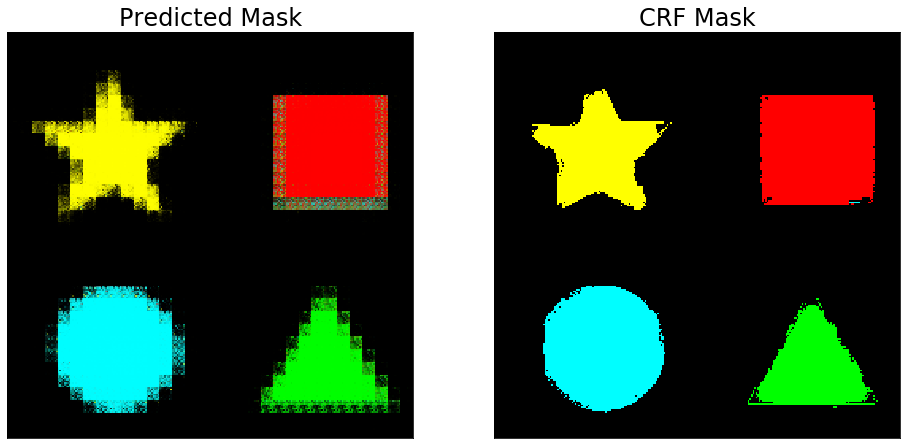

In [14]:
plot_pair([im_mask, res_crf], ['Predicted Mask', 'CRF Mask'])

### Performance Metrics

In [15]:
y_true = np.argmax(true_mask, axis=2)
y_pred = np.argmax(im_softmax, axis=2)

In [16]:
intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)
iou_score = np.sum(intersection) / np.sum(union)

print('IOU Softmax Mask: ', iou_score)

IOU Softmax Mask:  0.9894650610305562


In [17]:
intersection = np.logical_and(y_true, res)
union = np.logical_or(y_true, res)
iou_score = np.sum(intersection) / np.sum(union)

print('IOU CRF Mask: ', iou_score)

IOU CRF Mask:  0.9957172393423255
